# DS 11. 경사하강법과 확률적경사하강법, fashion_mnist

> "작성완료"

- toc: true
- branch: master
- badges: true
- comments: true
- [python, Data Science]

---
# Data Science
- lenture: Data Science_9-2nd week of lectures.
- lenture date: 2022-05-02
- lecturer: Guebin choi
- study date: 2022-05-04
- author: Kione kim
---

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

---
## 중간고사 리뷰

### 중간고사 3번문제

`-` 특이한 모형: 오버핏이 일어날 수 없는 모형 
- 유의미한 계수(coef): 상수항(bias), $\cos(t)$의 계수, $\cos(2t)$의 계수, $\cos(5t)$의 계수. 
- 유의미하지 않은 계수(coef): $\cos(3t)$의 계수, $\cos(4t)$의 계수 -> $\beta$값이 $0$
- 유의미하지 않은 계수는 $n%$이 커질수록 $\beta$가 $0$으로 추정된다 = $\cos(3t)$와 $\cos(5t)$는 사용자가 임의로 제외하지 않아도 모형에서 알아서 제거된다 = 모형이 알아서 유의미한 변수만 뽑아서 fit하기 때문에 overfit이 일어나지 않는다.

`-` 앞서 말한 것과 같이 3번문제의 모형은 overfit이 일어나지 않는데, 이러한 신기한 일이 일어나는 이유는 모든 설명변수가 직교하기 때문 => `orthogonal basis`
- 이런 모형의 장점: overfit이 일어날 위험이 없으므로 train/test로 나누어 학습할 이유가 없다. (샘플 낭비, test에 할당된 observation까지 모아서 학습해 $\beta$를 정확히 추론하는게 좋은 선택)
- 이러한 모형에서 할 일: 추정된 계수들이 0인지 아닌지 test하면 된다. (이것을 유의성검정이라고 한다) 

`-` 직교(orthogonal)기저 예시 
- 빨강과 파랑을 255,255만큼 섞으면 보라색이 된다. 
- 빨강과 파랑과 노랑을 각각 255,255,255만큼 섞으면 검은색이 된다. 
- 임의의 어떠한 색도 빨강,파랑,노랑의 조합으로 표현가능하다. 즉 $\text{color}= \text{red}*\beta_1 + \text{blue}*\beta_2 + \text{yellow}*\beta_3$ 이다. 
- (빨,파,노)는 색을 표현하는 basis이다. (적절한 $\beta_1,\beta_2,\beta_3$을 구하기만 하면 임의의 색도 표현가능)
- (빨,보,노)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요할때 보라색-빨간색을 하면되니까) 
- (빨,보,검)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요하면 보라색-빨간색을 하면되고, 노란색이 필요하면 검정색-보라색을 하면 되니까)
- (빨,파,노)는 직교기저이다. 
- 추후 재설명

### 중간고사 1-(3)번 문제

`-` 그림을 그려보자. 

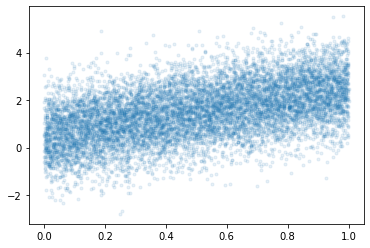

In [5]:
_x= tf.constant(np.arange(1,10001)/10000)
_y= tnp.random.randn(10000) + (0.5 + 2*_x) 
plt.plot(_x,_y,'.',alpha=0.1)

`-` 저것 꼭 10000개 다 모아서 loss계산해야할까? 

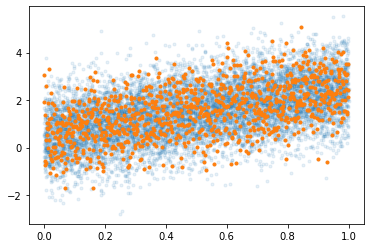

In [6]:
plt.plot(_x,_y,'.',alpha=0.1)
plt.plot(_x[::10],_y[::10],'.')

`-` 대충 이정도만 모아서 해도 비슷하지 않을까? $\to$ 해보자!

---

## 경사하강법과 확률적경사하강법

`-` 10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

### ver1: 모든 샘플을 사용하여 slope계산

(epoch1) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

...

### ver2: 하나의 샘플만 사용하여 slope계산 

(epoch1) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

질문: 어떤식으로 경사하강이 진행되지? 그래프 상에서? 한 에폭당 m번 경사하강이 진행됨..?

### ver3: $m(\leq n)$개의 샘플만 사용하여 slope계산

$m=3$이라고 하자. 

(epoch1) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

질문: 어떤식으로 경사하강이 진행되지? 총 n/m번 경사하강이 한 에폭당 진행되는데..?

### 용어정리 

#### 예전 (엄밀하게 구분)

`-` ver1: gradient descent, batch gradient descent 


`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient descent

#### 요즘 

`-` ver1: gradient descent


`-` ver2: stochastic gradient descent with batch size = 1 

`-` ver3: stochastic gradient descent 
- 참고) https://www.deeplearningbook.org/contents/optimization.html, 알고리즘 8-1

### Discussion 

`-` 핵심개념 
1. **메모리사용량: ver1 > ver3 > ver2** 

: ver1이 가장 많이 메모리를 잡아먹고 ver2가 가장 적게 메모리를 잡아먹음

2. 계산속도: ver2 > ver3 > ver1 

: ver2가 가장 빠르고 ver1이 가장 느림

3. local-min에 갇힘: ver1 > ver3 > ver2

: ver1이 local-minium에 가장 잘 갇히고 ver2가 가장 덜 갇힘

질문: 결국 버전1,2,3 모두 m개의 샘플 수를 모두 사용하는건데 계산속도에 차이가 왜 발생하는거지?
메모리사용량도 결국 m개의 샘플이 모두 사용되는건데 왜 차이가 나지?

질문: 반대로 글로벌미니멈으로 잘 가고 있는데 튀어나가서 로컬미니멈으로 갈 수도 있는 거 아닌가?

`-` 본질

GPU 메모리가 한정되어 있기 때문에 ver1을 쓰기 어렵다. 그렇지만 GPU 메모리를 가장 적게 쓰는 ver2는 너무 불안정하다. 

`-` 틀리지는 않지만 어색한 블로그 정리 내용들 
- 경사하강법은 종종 국소최소점에 갇히는 문제가 있다. 이를 해결하기 위해서 등장한 방법이 확률적 경사하강법이다.

: (반만 맞음) 어쩌다 보니 확률적 경사하강법이 local-minimum에서 더 잘 빠져나오는것 

- 경사하강법은 계산시간이 오래걸린다. 계산을 빠르게 하기 위해서 등장한 방법이 확률적 경사하강법이다. 

: (반만 맞음) "계산이 빠르다"의 의미는 1회 업데이트 속도가 빠르다는 의미인데, 최종적으로 수렴을 빨리시키는지는 알 수 없다. 돌려봐야 안다.

## fashion_mnist 모듈 

### tf.keras.datasets.fashion_mnist.load_data()

#### 모듈 및 데이터 탐색

In [5]:
type(tf.keras.datasets.fashion_mnist)

module

In [4]:
type(tf.keras.datasets.fashion_mnist.load_data)

function

---
함수인지 확인하는 방법

In [6]:
dir(tf.keras.datasets.fashion_mnist.load_data)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_keras_api_names',
 '_keras_api_names_v1']

- __call__이 있으면 함수임

cf. __eq__가 있으면 True, False 연산이 가능

In [7]:
tf.keras.datasets.fashion_mnist.load_data == 1

False

---

In [8]:
tf.keras.datasets.fashion_mnist.load_data??

Signature: tf.keras.datasets.fashion_mnist.load_data()
Source:   
@keras_export('keras.datasets.fashion_mnist.load_data')
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST.

  The classes are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

  **x_train**: uint8 NumPy array of grayscale image data with shapes
    `(60000, 28, 28)`, containing the training data.

  **y_train**: uint8 NumPy array of labels (integers in range 0-9)
    with shape `(60000,)` for the t

``` python
def load_data():
  return (x_train, y_train), (x_test, y_test)

이는 함수이고 return으로 (x_train, y_train), (x_test, y_test)이 반환됨
함수의 return값을 확인하면 (x_train, y_train), (x_test, y_test)로 결과를 받아야 코드가 예뻐짐을 알 수 있다. 
```  

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [14]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

- x_train는 60000개의 관측치(이미지의 수)를 가지고 있다. 
- 하나의 obs에 대한 x의 차원은 (28,28)이다. 
- 하나의 obs에 대한 y의 차원은 스칼라다. 

In [15]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

- train과 test의 비율은 6:1

In [16]:
type(x_train)

numpy.ndarray

- (깨알) numpy는 shape을 찍을 수 있음

`-` case1: x[0]

In [30]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [20]:
x_train[0].shape

(28, 28)

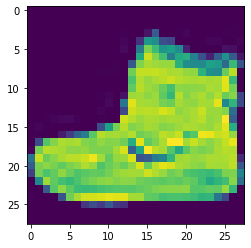

In [21]:
plt.imshow(x_train[0])

In [23]:
y_train[0]

9

- x_train[0]은 28*28의 매트릭스이고 이 매트릭스에 담긴 정보는 어떠한 신발 그림에 대한 것이고 이에 대응하는 y는 9이다.
- x_train[0]의 출력결과는 신발 그림을 나타내는 정보가 담긴 매트릭스이다.

`-` case2: x[1]

In [31]:
x_train[1]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

In [25]:
x_train[1].shape

(28, 28)

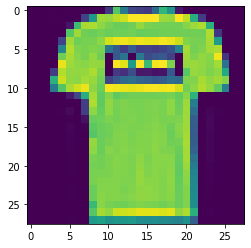

In [22]:
plt.imshow(x_train[1])

- 상의 그림이 나타남

In [26]:
y_train[1]

0

- x_train[1]은 28*28의 매트릭스이고 이 매트릭스에 담긴 정보는 어떠한 상의 그림에 대한 것이고 이에 대응하는 y는 0이다.
- x_train[1]의 출력결과는 상의 그림을 나타내는 정보가 담긴 매트릭스이다.

`-` case3: x[3]

In [29]:
x_train[2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 118,  24,   0,
          0,   0,   0,   0,  48,  88,   5,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  12, 100, 212, 205, 185,
        179, 173, 186, 193, 221, 142,  85,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  85,  76, 199, 225,
        248, 255, 238, 226, 157,  68,  80,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  91,  69,  91, 201,
        218, 225, 209, 158,  61,  93,  72,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  79,  89,  61,  59,
         87, 108,  75,  56,  76,  97,  73,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  75,  89,  80,  80,
         67,  63,  73,  83,  80,  96,  72,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [32]:
x_train[2].shape

(28, 28)

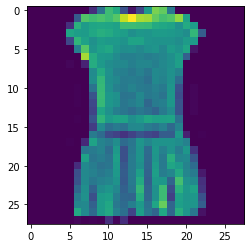

In [37]:
plt.imshow(x_train[3])

In [38]:
y_train[3]

3

- x_train[2]은 28*28의 매트릭스이고 이 매트릭스에 담긴 정보는 어떠한 원피스에 대한 것이고 이에 대응하는 y는 3이다.
- x_train[2]의 출력결과는 원피스 그림을 나타내는 정보가 담긴 매트릭스이다.

...

- x_train[n]은 28*28의 매트릭스이고 매트릭스에 해당 그림에 대한 정보가 담겨있으며, 그 그림에 따라 대응하는 y의 값이 달라진다.

`-` y_train의 값이 9인 것의 그림을 모두 보고싶다.

In [39]:
y_train == 9

array([ True, False, False, ..., False, False, False])

In [40]:
np.where(y_train == 9)

(array([    0,    11,    15, ..., 59932, 59970, 59978], dtype=int64),)

- 0번, 11번, 15번 등등 ... 의 인덱스에 해당하는 그림이 9에 값(y_train)을 갖는다.

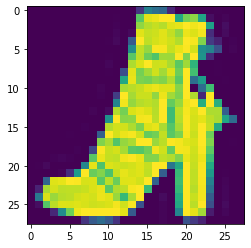

In [44]:
plt.imshow(x_train[11])

- 신발이 나왔다

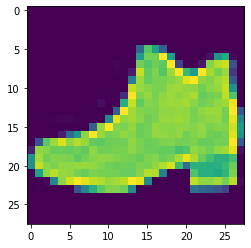

In [45]:
plt.imshow(x_train[15])

- 유추: y값이 9에 대응하는 그림은 모두 신발이다

#### 데이터구조

In [46]:
x_train.shape

(60000, 28, 28)

In [50]:
y_train[0]

9

- x: (n,28,28)
- y: (n,1)

### 예제1
로지스틱을 이용하여 y=0,1에 대응하는 이미지만 먼저 정리하자.

`-` 데이터정리

해야할 것: 28×28의 매트릭스를 보고 해당 그림이 0에 해당하는 것인지 1에 해당하는 것인지 맵핑해야 함
- 기존에 n×p의 매트릭스를 보고 y의 값을 예측했기 때문에 해당 데이터도 같은 형태로 정리. 즉 p가 28×28인 784임
- n×784의 매트릭스라 할 수 있음

`-` y=0,1인 데이터만 추출

---

In [57]:
np.array([True,True,False,False]) | np.array([True,False,True,False])

array([ True,  True,  True, False])

In [62]:
np.array([1,2,3,4])[np.array([True,False,True,False])]

array([1, 3])

---

In [65]:
y_train == 0

array([False,  True,  True, ..., False,  True, False])

In [73]:
(y_train == 0) | (y_train == 1)

array([False,  True,  True, ..., False,  True, False])

In [74]:
y_train[(y_train == 0) | (y_train == 1)]

array([0, 0, 0, ..., 1, 1, 0], dtype=uint8)

In [87]:
X=x_train[(y_train == 0) | (y_train == 1)]
y=y_train[(y_train == 0) | (y_train == 1)]

In [77]:
x.shape,y.shape

((12000, 28, 28), (12000,))

In [86]:
XX=x_test[(y_test == 0) | (y_test == 1)]
yy=y_test[(y_test == 0) | (y_test == 1)]

In [79]:
xx.shape,yy.shape

((2000, 28, 28), (2000,))

- train에 12000, test에 2000개의 데이터가 존재

- 하지만 이는 n×p 꼴임, n×784 꼴로 만들어줘야함

In [94]:
X=x_train[(y_train == 0) | (y_train == 1)].reshape(-1,784)
y=y_train[(y_train == 0) | (y_train == 1)]
XX=x_test[(y_test == 0) | (y_test == 1)].reshape(-1,784)
yy=y_test[(y_test == 0) | (y_test == 1)]

In [95]:
x.shape,y.shape, xx.shape,yy.shape

((12000, 784), (12000,), (2000, 784), (2000,))

- 원하는 형태로 정리 완료

#### 풀이1: 은닉층을 포함한 신경망  // epochs=100

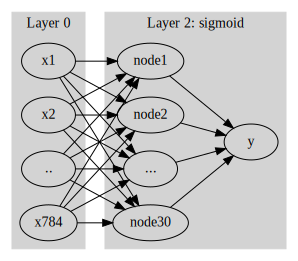

In [96]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: sigmoid"
}
''')

출력차원 30개로 선형결합 -> relu -> 출력차원 1로 선형결합 -> sigmoid

`-` 적합

In [122]:
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='sgd',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 1s 598ms/step - loss: 220.9144
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 6800.3174
Epoch 3/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7045
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 0.7012
Epoch 5/100
1/1 [==============================] - 0s 46ms/step - loss: 0.7004
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.6997
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 0.6991
Epoch 8/100
1/1 [==============================] - 0s 43ms/step - loss: 0.6985
Epoch 9/100
1/1 [==============================] - 0s 64ms/step - loss: 0.6979
Epoch 10/100
1/1 [==============================] - 0s 55ms/step - loss: 0.6976
Epoch 11/100
1/1 [==============================] - 0s 54ms/step - loss: 0.6973
Epoch 12/100
1/1 [==============================] - 0s 45ms/step - loss: 0.6970
Epoch 13/100
1/1 [=========================

---

In [123]:
net(X)

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.49997535],
       [0.49997535],
       [0.49997535],
       ...,
       [0.49997535],
       [0.49997535],
       [0.49997535]], dtype=float32)>

In [124]:
net(X) > 0.5

<tf.Tensor: shape=(12000, 1), dtype=bool, numpy=
array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])>

In [125]:
y

array([0, 0, 0, ..., 1, 1, 0], dtype=uint8)

In [126]:
(net(X) > 0.5) == y.reshape(12000,1)

<tf.Tensor: shape=(12000, 1), dtype=bool, numpy=
array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [ True]])>

In [127]:
np.sum((net(X) > 0.5) == y.reshape(12000,1))/12000

0.5000833333333333

In [128]:
np.mean((net(X) > 0.5) == y.reshape(12000,1))

0.5000833333333333

---

`-` test 결과

In [129]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.5

- 문제: 초기값에 따라 적합 결과가 차이가 매우 큼!
- 전략을 개선해서 풀어보자

#### 풀이2: 옵티마이저 개선

In [130]:
tf.random.set_seed(43055)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 1s 539ms/step - loss: 100.9425
Epoch 2/100
1/1 [==============================] - 0s 50ms/step - loss: 44.4441
Epoch 3/100
1/1 [==============================] - 0s 69ms/step - loss: 29.2322
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 22.6921
Epoch 5/100
1/1 [==============================] - 0s 58ms/step - loss: 8.7741
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 4.6409
Epoch 7/100
1/1 [==============================] - 0s 54ms/step - loss: 5.2642
Epoch 8/100
1/1 [==============================] - 0s 53ms/step - loss: 6.1993
Epoch 9/100
1/1 [==============================] - 0s 48ms/step - loss: 6.5543
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 6.3454
Epoch 11/100
1/1 [==============================] - 0s 64ms/step - loss: 5.7887
Epoch 12/100
1/1 [==============================] - 0s 46ms/step - loss: 5.1074
Epoch 13/100
1/1 [=========================

In [131]:
np.mean((net(X)>0.5) == y.reshape(12000,1))

0.99175

In [132]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.98

- 옵티마이저를 Adam으로 설정하니 적합이 잘 됨!
- `np.mean((net(X)>0.5) == y.reshape(2000,1))`입력하는 게 귀찮음! 

#### 풀이3: compile에 metrics=['accuracy'] 추가

In [134]:
#collapse_output
tf.random.set_seed(43055)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 1s 530ms/step - loss: 100.9425 - accuracy: 0.4988
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 44.4441 - accuracy: 0.3741
Epoch 3/100
1/1 [==============================] - 0s 66ms/step - loss: 29.2322 - accuracy: 0.4321
Epoch 4/100
1/1 [==============================] - 0s 52ms/step - loss: 22.6921 - accuracy: 0.5399
Epoch 5/100
1/1 [==============================] - 0s 68ms/step - loss: 8.7741 - accuracy: 0.7321
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 4.6409 - accuracy: 0.8516
Epoch 7/100
1/1 [==============================] - 0s 75ms/step - loss: 5.2642 - accuracy: 0.8711
Epoch 8/100
1/1 [==============================] - 0s 61ms/step - loss: 6.1993 - accuracy: 0.8771
Epoch 9/100
1/1 [==============================] - 0s 50ms/step - loss: 6.5543 - accuracy: 0.8845
Epoch 10/100
1/1 [==============================] - 0s 64ms/step - loss: 6.3454 - accuracy: 0.8953
Epoch 11/100


`-` 정확도를 계산하는 또 다른 코드

In [135]:
net.evaluate(X,y)

375/375 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9918


[0.10858087986707687, 0.9917500019073486]

In [136]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 3ms/step - loss: 0.2933 - accuracy: 0.9800


[0.2932807505130768, 0.9800000190734863]

#### 풀이4: 확률적경사하강법 이용 // epochs=10

In [143]:
#collapse_output
tf.random.set_seed(43055)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=120) 

Epoch 1/10
100/100 [==============================] - 1s 3ms/step - loss: 3.5696 - accuracy: 0.9374
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3958 - accuracy: 0.9795
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.2036 - accuracy: 0.9865
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9871
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1515 - accuracy: 0.9872
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1036 - accuracy: 0.9890
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0669 - accuracy: 0.9908
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0653 - accuracy: 0.9912
Epoch 9/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0533 - accuracy: 0.9936
Epoch 10/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0475 - accuracy: 0.9931

In [144]:
net.evaluate(X,y)

375/375 [==============================] - 1s 2ms/step - loss: 0.1111 - accuracy: 0.9806


[0.11114658415317535, 0.9805833101272583]

In [145]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 3ms/step - loss: 0.3473 - accuracy: 0.9745


[0.3472752571105957, 0.9745000004768372]

- 잘 적합된다.

- 100/100이 의미하는 것은 batch_size 120이 100번 돌아 총 12000개의 샘플이 하나의 에폭에서 적합된 것이다.
- 처음 에폭에서 적합된 0.9374는 120개의 샘플이 100번 적합된 것이다.